In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install pymysql

     |████████████████████████████████| 51kB 3.9MB/s 


# 1) MySQL Connection

In [0]:
import pymysql

In [0]:
# Details ommited from public.

'''
fin_conn = pymysql.connect(host= , 
                       port=, 
                       user=, 
                       passwd=, 
                       db = )
'''

## Financial Database Tables 

In [0]:
# Tables in Financial Database:

fin_table_names = ['card', 'disp', 'trans', 'order', 'loan', 'client', 'account', 'district']

## Data Description

Data description from [link text](https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm)

[Another reference link](https://relational.fit.cvut.cz/dataset/Financial)

The data about the clients and their accounts consist of following relations:

* relation **account** (4500 objects in the file ACCOUNT.ASC) - each record describes static characteristics of an account,

* relation **client** (5369 objects in the file CLIENT.ASC) - each record describes characteristics of a client,

* relation **disposition** (disp) (5369 objects in the file DISP.ASC) - each record relates together a client with an account,

* relation **permanent order** (6471 objects in the file ORDER.ASC) - each record describes characteristics of a payment order,
* relation **transaction** (1056320 objects in the file TRANS.ASC) - each record describes one transaction on an account,
* relation **loan** (682 objects in the file LOAN.ASC) - each record describes a loan granted for a given account,
* relation **credit card** (892 objects in the file CARD.ASC) - each record describes a credit card issued to an account,
* relation **demographic data** (77 objects in the file DISTRICT.ASC) - each record describes demographic characteristics of a district.

In [0]:
loans_table = pd.read_sql("SELECT * FROM loan", fin_conn)

In [0]:
loans_table

,loan_id,account_id,date,amount,duration,payments,status
0,4959,2,1994-01-05,80952,24,3373.0,A
1,4961,19,1996-04-29,30276,12,2523.0,B
2,4962,25,1997-12-08,30276,12,2523.0,A
3,4967,37,1998-10-14,318480,60,5308.0,D
4,4968,38,1998-04-19,110736,48,2307.0,C
...,...,...,...,...,...,...,...
677,7294,11327,1998-09-27,39168,24,1632.0,C
678,7295,11328,1998-07-18,280440,60,4674.0,C
679,7304,11349,1995-10-29,419880,60,6998.0,C
680,7305,11359,1996-08-06,54024,12,4502.0,A


In [0]:
loans_table.status.value_counts()

C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [0]:
loans_table.account_id.nunique()

682

### Using SQL To Pull Data

Reference: https://medium.com/henry-jia/bank-loan-default-prediction-with-machine-learning-e9336d19dffa


In the `financial` database (for this project), the tables of interest here are:

* card
* disp
* account
* trans
* ~~order~~
* loan

---

The big two tables are `trans` and `loan`.

From `trans` I want to obtain:

* operation (transaction mode)
* number of transactions for each account
* average amount of the account's transactions on the latest date

From the `loans` table I want:

* amount
* date
* duration
* payments
* status

#### Transaction Table Data Pull

In [0]:
# Look at trans (tranasctions) table:

transactions_table = pd.read_sql("SELECT * FROM trans", fin_conn)

In [0]:
transactions_table

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1,1,1995-03-24,PRIJEM,VKLAD,1000,1000,None,None,NaN
1,5,1,1995-04-13,PRIJEM,PREVOD Z UCTU,3679,4679,None,AB,41403269.0
2,6,1,1995-05-13,PRIJEM,PREVOD Z UCTU,3679,20977,None,AB,41403269.0
3,7,1,1995-06-13,PRIJEM,PREVOD Z UCTU,3679,26835,None,AB,41403269.0
4,8,1,1995-07-13,PRIJEM,PREVOD Z UCTU,3679,30415,None,AB,41403269.0
...,...,...,...,...,...,...,...,...,...,...
1056315,3682983,10451,1998-08-31,PRIJEM,None,62,17300,UROK,None,NaN
1056316,3682984,10451,1998-09-30,PRIJEM,None,49,13442,UROK,None,NaN
1056317,3682985,10451,1998-10-31,PRIJEM,None,34,10118,UROK,None,NaN
1056318,3682986,10451,1998-11-30,PRIJEM,None,26,8398,UROK,None,NaN


In [0]:
transactions_table.columns

Index(['trans_id', 'account_id', 'date', 'type', 'operation', 'amount',
       'balance', 'k_symbol', 'bank', 'account'],
      dtype='object')

The `operation` column in the `trans` table refers to the mode of transaction.

* "VYBER KARTOU" credit card withdrawal (into cc_withdrawal)
* "VKLAD" credit in cash (credit in cash)
* "PREVOD Z UCTU" collection from another bank (collect from diff bank)
* "VYBER" withdrawal in cash (cash withdraw)
* "PREVOD NA UCET" remittance to another bank (remit to diff bank)

In [0]:
# Obtain information from trans table:

transactions_info = pd.read_sql(
'''
SELECT t.account_id, COUNT(t.trans_id) AS num_tsns, MAX(t.date) AS last_tsn_date,
SUM(CASE WHEN t.operation = 'VYBER KARTOU' THEN 1 ELSE 0 END) AS num_cc_withdraw,
SUM(CASE WHEN t.operation = 'VKLAD' THEN 1 ELSE 0 END ) AS num_credit_in_cash,
SUM(CASE WHEN t.operation = 'PREVOD Z UCTU' THEN 1 ELSE 0 END) AS num_collect_from_diff_bank,
SUM(CASE WHEN t.operation = 'VYBER' THEN 1 ELSE 0 END) AS num_cash_withdraw,
SUM(CASE WHEN t.operation = 'PREVOD NA UCET' THEN 1 ELSE 0 END) AS num_remit_to_diff_bank,
AVG(CASE WHEN t.operation = 'VYBER KARTOU' THEN t.amount ELSE 0 END) AS avg_cc_withdraw,
AVG(CASE WHEN t.operation = 'VKLAD' THEN t.amount ELSE 0 END) AS avg_credit_in_cash,
AVG(CASE WHEN t.operation = 'PREVOD Z UCTU' THEN  t.amount ELSE 0 END) AS avg_collect_from_diff_bank,
AVG(CASE WHEN t.operation = 'VYBER' THEN  t.amount ELSE 0 END) AS avg_cash_withdraw,
AVG(CASE WHEN t.operation = 'PREVOD NA UCET' THEN  t.amount ELSE 0 END) AS avg_remit_to_diff_bank
FROM trans as t
GROUP BY t.account_id;''',
fin_conn)

In [0]:
transactions_info

,account_id,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,1,239,1998-12-31,0.0,12.0,45.0,97.0,40.0,0.0000,107.5314,692.6987,346.4017,410.3766
1,2,478,1998-12-31,0.0,12.0,70.0,237.0,89.0,0.0000,101.2552,3217.4393,2094.5962,1157.4100
2,3,117,1998-12-31,0.0,28.0,0.0,32.0,39.0,0.0000,1461.4444,0.0000,486.7949,555.6667
3,4,186,1998-12-31,0.0,1.0,34.0,62.0,59.0,0.0000,4.3011,1015.0645,321.6398,531.2473
4,5,84,1998-12-31,0.0,1.0,19.0,35.0,14.0,0.0000,7.1429,1134.7976,381.5476,444.6667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,11333,368,1998-12-31,0.0,78.0,0.0,185.0,0.0,0.0000,4511.3995,0.0000,4398.8016,0.0000
4496,11349,304,1998-12-31,0.0,5.0,43.0,136.0,77.0,0.0000,48.6842,6491.5658,4181.6414,2271.3092
4497,11359,378,1998-12-31,22.0,2.0,51.0,148.0,104.0,151.8519,10.5820,3966.3413,2924.6534,723.6402
4498,11362,344,1998-12-31,0.0,43.0,0.0,103.0,160.0,0.0000,1976.9041,0.0000,977.6599,899.5291


#### Non-Transactions Table Data Pull

In [0]:
# Obtain information from trans (transactions) table:
# Using the tables card -> disp -> account -> trans -> loan
# The loan table contains the target variable being status (A, B, C, D)


other_info = pd.read_sql(
'''
SELECT card.card_id, card.type, card.issued, a.account_id, a.frequency, 
l.amount, l.date, l.duration, l.payments, l.status 
FROM 
card 
LEFT JOIN disp as d
ON card.disp_id = d.disp_id
LEFT JOIN account as a
ON d.account_id = a.account_id
LEFT JOIN loan as l
ON a.account_id = l.account_id;
''',
fin_conn)

In [0]:
other_info

,card_id,type,issued,account_id,frequency,amount,date,duration,payments,status
0,1,gold,1998-10-16,7,POPLATEK MESICNE,NaN,None,NaN,NaN,None
1,2,classic,1998-03-13,14,POPLATEK MESICNE,NaN,None,NaN,NaN,None
2,3,gold,1995-09-03,33,POPLATEK MESICNE,NaN,None,NaN,NaN,None
3,4,classic,1998-11-26,34,POPLATEK TYDNE,NaN,None,NaN,NaN,None
4,5,junior,1995-04-24,43,POPLATEK MESICNE,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...
887,1230,classic,1998-03-08,11079,POPLATEK MESICNE,98304.0,1997-04-26,12.0,8192.0,A
888,1233,classic,1996-07-06,11138,POPLATEK TYDNE,89880.0,1996-01-19,24.0,3745.0,A
889,1234,classic,1997-11-28,11141,POPLATEK TYDNE,44940.0,1997-10-07,12.0,3745.0,A
890,1239,junior,1998-02-02,11186,POPLATEK MESICNE,392460.0,1996-10-02,60.0,6541.0,C


#### Joined Table (682 Rows = 606 success + 76 Not Successful)

In [0]:
# Joined table:
# loan -> trans -> account -> disp -> card

joined_table = pd.read_sql(
'''
SELECT a.account_id, a.frequency, l.amount AS loan_amount, 
l.date AS loan_date, l.duration loan_duration, l.payments AS loan_pmt, 
l.status, c.type AS card_type, d.type AS disp_type,
COUNT(t.trans_id) AS num_tsns, MAX(t.date) AS last_tsn_date,
SUM(CASE WHEN t.operation = 'VYBER KARTOU' THEN 1 ELSE 0 END) AS num_cc_withdraw,
SUM(CASE WHEN t.operation = 'VKLAD' THEN 1 ELSE 0 END ) AS num_credit_in_cash,
SUM(CASE WHEN t.operation = 'PREVOD Z UCTU' THEN 1 ELSE 0 END) AS num_collect_from_diff_bank,
SUM(CASE WHEN t.operation = 'VYBER' THEN 1 ELSE 0 END) AS num_cash_withdraw,
SUM(CASE WHEN t.operation = 'PREVOD NA UCET' THEN 1 ELSE 0 END) AS num_remit_to_diff_bank,
AVG(CASE WHEN t.operation = 'VYBER KARTOU' THEN t.amount ELSE 0 END) AS avg_cc_withdraw,
AVG(CASE WHEN t.operation = 'VKLAD' THEN t.amount ELSE 0 END) AS avg_credit_in_cash,
AVG(CASE WHEN t.operation = 'PREVOD Z UCTU' THEN  t.amount ELSE 0 END) AS avg_collect_from_diff_bank,
AVG(CASE WHEN t.operation = 'VYBER' THEN  t.amount ELSE 0 END) AS avg_cash_withdraw,
AVG(CASE WHEN t.operation = 'PREVOD NA UCET' THEN  t.amount ELSE 0 END) AS avg_remit_to_diff_bank
FROM 
loan as l
JOIN trans as t
ON l.account_id = t.account_id
JOIN account as a
ON t.account_id = a.account_id
JOIN disp as d
ON a.account_id = d.account_id
LEFT JOIN card as c
ON d.disp_id = c.disp_id
GROUP BY a.account_id;''',
fin_conn)


In [0]:
joined_table

,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,2,POPLATEK MESICNE,80952,1994-01-05,24,3373.0,A,None,OWNER,956,1998-12-31,0.0,24.0,140.0,474.0,178.0,0.0000,101.2552,3217.4393,2094.5962,1157.4100
1,19,POPLATEK MESICNE,30276,1996-04-29,12,2523.0,B,None,OWNER,303,1998-12-31,0.0,17.0,45.0,143.0,8.0,0.0000,151.1551,2448.2079,2515.3531,66.6139
2,25,POPLATEK MESICNE,30276,1997-12-08,12,2523.0,A,None,OWNER,274,1998-12-31,0.0,54.0,0.0,99.0,93.0,0.0000,5431.2847,0.0000,4435.9416,907.7847
3,37,POPLATEK MESICNE,318480,1998-10-14,60,5308.0,D,None,OWNER,130,1998-12-31,0.0,19.0,0.0,51.0,43.0,0.0000,3803.8000,0.0000,2891.1538,579.0769
4,38,POPLATEK TYDNE,110736,1998-04-19,48,2307.0,C,None,OWNER,130,1998-12-31,0.0,14.0,17.0,37.0,45.0,0.0000,382.3077,1969.6923,1205.2231,823.1308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,POPLATEK MESICNE,39168,1998-09-27,24,1632.0,C,None,OWNER,75,1998-12-31,0.0,16.0,0.0,33.0,12.0,0.0000,4204.9867,0.0000,2708.4667,508.4400
678,11328,POPLATEK MESICNE,280440,1998-07-18,60,4674.0,C,None,OWNER,146,1998-12-31,0.0,38.0,0.0,78.0,5.0,0.0000,4727.8151,0.0000,4166.1301,160.0685
679,11349,POPLATEK TYDNE,419880,1995-10-29,60,6998.0,C,None,OWNER,608,1998-12-31,0.0,10.0,86.0,272.0,154.0,0.0000,48.6842,6491.5658,4181.6414,2271.3092
680,11359,POPLATEK MESICNE,54024,1996-08-06,12,4502.0,A,classic,OWNER,378,1998-12-31,22.0,2.0,51.0,148.0,104.0,151.8519,10.5820,3966.3413,2924.6534,723.6402


In [0]:
# Check NA values:

joined_table.isna().sum()

account_id                      0
frequency                       0
loan_amount                     0
loan_date                       0
loan_duration                   0
loan_pmt                        0
status                          0
card_type                     512
disp_type                       0
num_tsns                        0
last_tsn_date                   0
num_cc_withdraw                 0
num_credit_in_cash              0
num_collect_from_diff_bank      0
num_cash_withdraw               0
num_remit_to_diff_bank          0
avg_cc_withdraw                 0
avg_credit_in_cash              0
avg_collect_from_diff_bank      0
avg_cash_withdraw               0
avg_remit_to_diff_bank          0
dtype: int64

In [0]:
# Convert NULL card type values to None:

joined_table['card_type'] = joined_table['card_type'].fillna('None')

In [0]:
joined_table.isna().sum()

account_id                    0
frequency                     0
loan_amount                   0
loan_date                     0
loan_duration                 0
loan_pmt                      0
status                        0
card_type                     0
disp_type                     0
num_tsns                      0
last_tsn_date                 0
num_cc_withdraw               0
num_credit_in_cash            0
num_collect_from_diff_bank    0
num_cash_withdraw             0
num_remit_to_diff_bank        0
avg_cc_withdraw               0
avg_credit_in_cash            0
avg_collect_from_diff_bank    0
avg_cash_withdraw             0
avg_remit_to_diff_bank        0
dtype: int64

In [0]:
joined_table['account_id'].nunique()

682

In [0]:
joined_table.shape

(682, 20)

In [0]:
# Check that there are still the same as the one from loans table.

joined_table.status.value_counts() == loans_table.status.value_counts()

C    True
A    True
D    True
B    True
Name: status, dtype: bool

In [0]:
joined_table.status.value_counts()

C    403
A    203
D     45
B     31
Name: status, dtype: int64

### Close Connection

In [0]:
# Close connection.

fin_conn.close()

# 2) Save Joined_Table As .csv File

In [0]:
# Save full data as .csv (for now as of Thurs Nov 21 evening):

joined_table.to_csv('pulled_loan_data.csv', index=False)

# 3) Import Joined Tables Loan Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import bank data.

bank_loan_df = pd.read_csv('/content/drive/My Drive/pulled_loan_data.csv')

In [0]:
# Preview:

bank_loan_df

,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,2,POPLATEK MESICNE,80952,1994-01-05,24,3373.0,A,None,OWNER,956,1998-12-31,0.0,24.0,140.0,474.0,178.0,0.0000,101.2552,3217.4393,2094.5962,1157.4100
1,19,POPLATEK MESICNE,30276,1996-04-29,12,2523.0,B,None,OWNER,303,1998-12-31,0.0,17.0,45.0,143.0,8.0,0.0000,151.1551,2448.2079,2515.3531,66.6139
2,25,POPLATEK MESICNE,30276,1997-12-08,12,2523.0,A,None,OWNER,274,1998-12-31,0.0,54.0,0.0,99.0,93.0,0.0000,5431.2847,0.0000,4435.9416,907.7847
3,37,POPLATEK MESICNE,318480,1998-10-14,60,5308.0,D,None,OWNER,130,1998-12-31,0.0,19.0,0.0,51.0,43.0,0.0000,3803.8000,0.0000,2891.1538,579.0769
4,38,POPLATEK TYDNE,110736,1998-04-19,48,2307.0,C,None,OWNER,130,1998-12-31,0.0,14.0,17.0,37.0,45.0,0.0000,382.3077,1969.6923,1205.2231,823.1308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,POPLATEK MESICNE,39168,1998-09-27,24,1632.0,C,None,OWNER,75,1998-12-31,0.0,16.0,0.0,33.0,12.0,0.0000,4204.9867,0.0000,2708.4667,508.4400
678,11328,POPLATEK MESICNE,280440,1998-07-18,60,4674.0,C,None,OWNER,146,1998-12-31,0.0,38.0,0.0,78.0,5.0,0.0000,4727.8151,0.0000,4166.1301,160.0685
679,11349,POPLATEK TYDNE,419880,1995-10-29,60,6998.0,C,None,OWNER,608,1998-12-31,0.0,10.0,86.0,272.0,154.0,0.0000,48.6842,6491.5658,4181.6414,2271.3092
680,11359,POPLATEK MESICNE,54024,1996-08-06,12,4502.0,A,classic,OWNER,378,1998-12-31,22.0,2.0,51.0,148.0,104.0,151.8519,10.5820,3966.3413,2924.6534,723.6402


In [0]:
# Shape

bank_loan_df.shape

(682, 21)

# 4) Data Cleaning Tasks

1. Change statuses A and C to accepted and B and D to rejected.

2. Check for dates if it needs fixing.

3. I need to change some of the Czech string text into usable english strings. 


In [0]:
bank_loan_df.head(3)

,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,2,POPLATEK MESICNE,80952,1994-01-05,24,3373.0,A,None,OWNER,956,1998-12-31,0.0,24.0,140.0,474.0,178.0,0.0,101.2552,3217.4393,2094.5962,1157.4100
1,19,POPLATEK MESICNE,30276,1996-04-29,12,2523.0,B,None,OWNER,303,1998-12-31,0.0,17.0,45.0,143.0,8.0,0.0,151.1551,2448.2079,2515.3531,66.6139
2,25,POPLATEK MESICNE,30276,1997-12-08,12,2523.0,A,None,OWNER,274,1998-12-31,0.0,54.0,0.0,99.0,93.0,0.0,5431.2847,0.0000,4435.9416,907.7847


## Changing Letters To 0s and 1s In status Column

The status column contains the status for paying off the loan. 

* 'A' stands for contract finished, no problems,
* 'B' stands for contract finished, loan not payed,
* 'C' stands for running contract, OK so far,
* 'D' stands for running contract, client in debt

---

Need to change As and Cs to 1s, Bs and Ds to 0s.

A status of 1 represents the account being in good standing. Statuses of zero refers to a rejection of a new loan.

In [0]:
# Change As and Cs to 1s and B and Ds to 0s in status column
# status column is accepted or rejected application for bank loan

bank_loan_df['status'] = bank_loan_df['status'].map({'A': 1, 'B': 0, 'C': 1, 'D': 0})

In [0]:
bank_loan_df

,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,2,POPLATEK MESICNE,80952,1994-01-05,24,3373.0,1,None,OWNER,956,1998-12-31,0.0,24.0,140.0,474.0,178.0,0.0000,101.2552,3217.4393,2094.5962,1157.4100
1,19,POPLATEK MESICNE,30276,1996-04-29,12,2523.0,0,None,OWNER,303,1998-12-31,0.0,17.0,45.0,143.0,8.0,0.0000,151.1551,2448.2079,2515.3531,66.6139
2,25,POPLATEK MESICNE,30276,1997-12-08,12,2523.0,1,None,OWNER,274,1998-12-31,0.0,54.0,0.0,99.0,93.0,0.0000,5431.2847,0.0000,4435.9416,907.7847
3,37,POPLATEK MESICNE,318480,1998-10-14,60,5308.0,0,None,OWNER,130,1998-12-31,0.0,19.0,0.0,51.0,43.0,0.0000,3803.8000,0.0000,2891.1538,579.0769
4,38,POPLATEK TYDNE,110736,1998-04-19,48,2307.0,1,None,OWNER,130,1998-12-31,0.0,14.0,17.0,37.0,45.0,0.0000,382.3077,1969.6923,1205.2231,823.1308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,POPLATEK MESICNE,39168,1998-09-27,24,1632.0,1,None,OWNER,75,1998-12-31,0.0,16.0,0.0,33.0,12.0,0.0000,4204.9867,0.0000,2708.4667,508.4400
678,11328,POPLATEK MESICNE,280440,1998-07-18,60,4674.0,1,None,OWNER,146,1998-12-31,0.0,38.0,0.0,78.0,5.0,0.0000,4727.8151,0.0000,4166.1301,160.0685
679,11349,POPLATEK TYDNE,419880,1995-10-29,60,6998.0,1,None,OWNER,608,1998-12-31,0.0,10.0,86.0,272.0,154.0,0.0000,48.6842,6491.5658,4181.6414,2271.3092
680,11359,POPLATEK MESICNE,54024,1996-08-06,12,4502.0,1,classic,OWNER,378,1998-12-31,22.0,2.0,51.0,148.0,104.0,151.8519,10.5820,3966.3413,2924.6534,723.6402


## Checking & Converting Date Columns

`issued` and `date` columns in the dataset contains dates

In [0]:
# Check columns with dates.

bank_loan_df[['loan_date', 'last_tsn_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 2 columns):
loan_date        682 non-null object
last_tsn_date    682 non-null object
dtypes: object(2)
memory usage: 10.8+ KB


In [0]:
# Change date and last_tsn_date columns into datetime columns:

bank_loan_df['loan_date'] = pd.to_datetime(bank_loan_df['loan_date'])

bank_loan_df['last_tsn_date'] = pd.to_datetime(bank_loan_df['last_tsn_date'])

In [0]:
bank_loan_df.head()

,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,2,POPLATEK MESICNE,80952,1994-01-05,24,3373.0,1,None,OWNER,956,1998-12-31,0.0,24.0,140.0,474.0,178.0,0.0,101.2552,3217.4393,2094.5962,1157.4100
1,19,POPLATEK MESICNE,30276,1996-04-29,12,2523.0,0,None,OWNER,303,1998-12-31,0.0,17.0,45.0,143.0,8.0,0.0,151.1551,2448.2079,2515.3531,66.6139
2,25,POPLATEK MESICNE,30276,1997-12-08,12,2523.0,1,None,OWNER,274,1998-12-31,0.0,54.0,0.0,99.0,93.0,0.0,5431.2847,0.0000,4435.9416,907.7847
3,37,POPLATEK MESICNE,318480,1998-10-14,60,5308.0,0,None,OWNER,130,1998-12-31,0.0,19.0,0.0,51.0,43.0,0.0,3803.8000,0.0000,2891.1538,579.0769
4,38,POPLATEK TYDNE,110736,1998-04-19,48,2307.0,1,None,OWNER,130,1998-12-31,0.0,14.0,17.0,37.0,45.0,0.0,382.3077,1969.6923,1205.2231,823.1308


In [0]:
bank_loan_df[['loan_date', 'last_tsn_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 2 columns):
loan_date        682 non-null datetime64[ns]
last_tsn_date    682 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 10.8 KB


## Translating Czech Text Into English In Columns

In the dataset, some of the columns contain Czech text. There is a data dictionary from [this link](https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm).

**Columns Of Interest**

* frequency
* operation
* k_symbol


### frequency Column Translation

In [0]:
# Check unique values in frequency column:

bank_loan_df['frequency'].unique()

array(['POPLATEK MESICNE', 'POPLATEK TYDNE', 'POPLATEK PO OBRATU'],
      dtype=object)

In [0]:
# Change Czech text into monthly issuance, weekly issuance and issuance after transaction.

bank_loan_df['frequency'] = bank_loan_df['frequency'].map(
                          {'POPLATEK MESICNE': 'mth_issuance',
                           'POPLATEK TYDNE': 'weekly_issuance',
                           'POPLATEK PO OBRATU': 'after_tsn_issuance'})

In [0]:
# Check .head

bank_loan_df.tail()

,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
677,11327,mth_issuance,39168,1998-09-27,24,1632.0,1,None,OWNER,75,1998-12-31,0.0,16.0,0.0,33.0,12.0,0.0000,4204.9867,0.0000,2708.4667,508.4400
678,11328,mth_issuance,280440,1998-07-18,60,4674.0,1,None,OWNER,146,1998-12-31,0.0,38.0,0.0,78.0,5.0,0.0000,4727.8151,0.0000,4166.1301,160.0685
679,11349,weekly_issuance,419880,1995-10-29,60,6998.0,1,None,OWNER,608,1998-12-31,0.0,10.0,86.0,272.0,154.0,0.0000,48.6842,6491.5658,4181.6414,2271.3092
680,11359,mth_issuance,54024,1996-08-06,12,4502.0,1,classic,OWNER,378,1998-12-31,22.0,2.0,51.0,148.0,104.0,151.8519,10.5820,3966.3413,2924.6534,723.6402
681,11362,mth_issuance,129408,1996-12-27,24,5392.0,1,None,OWNER,344,1998-12-31,0.0,43.0,0.0,103.0,160.0,0.0000,1976.9041,0.0000,977.6599,899.5291


## Remove k_symbol Column

The data pull did not work with regards to the k_symbol column. This column will be removed.


~~Not to be confused with `K_symbol` from the `order` table which was not in the dataset (joined table).~~

~~k_symbol = characterization of the transaction~~

* ~~"POJISTNE" stands for insurrance payment~~
* ~~"SLUZBY" stands for payment for statement~~
* ~~"UROK" stands for interest credited~~
* ~~"SANKC. UROK" sanction interest if negative balance~~
* ~~"SIPO" stands for household~~
* ~~"DUCHOD" stands for old-age pension~~
* ~~"UVER" stands for loan payment~~

In [0]:
# bank_loan_df.drop(columns = 'k_symbol', inplace = True)

KeyError: ignored

In [0]:
# Check dataframe:

bank_loan_df

,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,2,mth_issuance,80952,1994-01-05,24,3373.0,1,None,OWNER,956,1998-12-31,0.0,24.0,140.0,474.0,178.0,0.0000,101.2552,3217.4393,2094.5962,1157.4100
1,19,mth_issuance,30276,1996-04-29,12,2523.0,0,None,OWNER,303,1998-12-31,0.0,17.0,45.0,143.0,8.0,0.0000,151.1551,2448.2079,2515.3531,66.6139
2,25,mth_issuance,30276,1997-12-08,12,2523.0,1,None,OWNER,274,1998-12-31,0.0,54.0,0.0,99.0,93.0,0.0000,5431.2847,0.0000,4435.9416,907.7847
3,37,mth_issuance,318480,1998-10-14,60,5308.0,0,None,OWNER,130,1998-12-31,0.0,19.0,0.0,51.0,43.0,0.0000,3803.8000,0.0000,2891.1538,579.0769
4,38,weekly_issuance,110736,1998-04-19,48,2307.0,1,None,OWNER,130,1998-12-31,0.0,14.0,17.0,37.0,45.0,0.0000,382.3077,1969.6923,1205.2231,823.1308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,mth_issuance,39168,1998-09-27,24,1632.0,1,None,OWNER,75,1998-12-31,0.0,16.0,0.0,33.0,12.0,0.0000,4204.9867,0.0000,2708.4667,508.4400
678,11328,mth_issuance,280440,1998-07-18,60,4674.0,1,None,OWNER,146,1998-12-31,0.0,38.0,0.0,78.0,5.0,0.0000,4727.8151,0.0000,4166.1301,160.0685
679,11349,weekly_issuance,419880,1995-10-29,60,6998.0,1,None,OWNER,608,1998-12-31,0.0,10.0,86.0,272.0,154.0,0.0000,48.6842,6491.5658,4181.6414,2271.3092
680,11359,mth_issuance,54024,1996-08-06,12,4502.0,1,classic,OWNER,378,1998-12-31,22.0,2.0,51.0,148.0,104.0,151.8519,10.5820,3966.3413,2924.6534,723.6402


## Some Columns Should Be From Float To Int

These five columns have float values and should be converted into integers as they are count values.

* num_cc_withdraw	
* num_credit_in_cash	
* num_collect_from_diff_bank	
* num_cash_withdraw	
* num_remit_to_diff_bank	

In [0]:
num_columns = ['num_cc_withdraw',
               'num_credit_in_cash',
               'num_collect_from_diff_bank',	
               'num_cash_withdraw',	
               'num_remit_to_diff_bank']

In [0]:
# Convert from float to int fror the five columns

for num_col in num_columns:
  bank_loan_df[num_col] = bank_loan_df[num_col].astype(int)

In [0]:
# Check data type:

bank_loan_df[num_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 5 columns):
num_cc_withdraw               682 non-null int64
num_credit_in_cash            682 non-null int64
num_collect_from_diff_bank    682 non-null int64
num_cash_withdraw             682 non-null int64
num_remit_to_diff_bank        682 non-null int64
dtypes: int64(5)
memory usage: 26.8 KB


In [0]:
# Preview:

display(bank_loan_df.head())

display(bank_loan_df.tail())

,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,2,mth_issuance,80952,1994-01-05,24,3373.0,1,None,OWNER,956,1998-12-31,0,24,140,474,178,0.0,101.2552,3217.4393,2094.5962,1157.4100
1,19,mth_issuance,30276,1996-04-29,12,2523.0,0,None,OWNER,303,1998-12-31,0,17,45,143,8,0.0,151.1551,2448.2079,2515.3531,66.6139
2,25,mth_issuance,30276,1997-12-08,12,2523.0,1,None,OWNER,274,1998-12-31,0,54,0,99,93,0.0,5431.2847,0.0000,4435.9416,907.7847
3,37,mth_issuance,318480,1998-10-14,60,5308.0,0,None,OWNER,130,1998-12-31,0,19,0,51,43,0.0,3803.8000,0.0000,2891.1538,579.0769
4,38,weekly_issuance,110736,1998-04-19,48,2307.0,1,None,OWNER,130,1998-12-31,0,14,17,37,45,0.0,382.3077,1969.6923,1205.2231,823.1308


,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
677,11327,mth_issuance,39168,1998-09-27,24,1632.0,1,None,OWNER,75,1998-12-31,0,16,0,33,12,0.0000,4204.9867,0.0000,2708.4667,508.4400
678,11328,mth_issuance,280440,1998-07-18,60,4674.0,1,None,OWNER,146,1998-12-31,0,38,0,78,5,0.0000,4727.8151,0.0000,4166.1301,160.0685
679,11349,weekly_issuance,419880,1995-10-29,60,6998.0,1,None,OWNER,608,1998-12-31,0,10,86,272,154,0.0000,48.6842,6491.5658,4181.6414,2271.3092
680,11359,mth_issuance,54024,1996-08-06,12,4502.0,1,classic,OWNER,378,1998-12-31,22,2,51,148,104,151.8519,10.5820,3966.3413,2924.6534,723.6402
681,11362,mth_issuance,129408,1996-12-27,24,5392.0,1,None,OWNER,344,1998-12-31,0,43,0,103,160,0.0000,1976.9041,0.0000,977.6599,899.5291


## Rounding Money To Two Decimal Places

In [0]:
# The aggregated averages columns (trans table)
# in the dataset

avg_columns = ['avg_cc_withdraw',	
               'avg_credit_in_cash',	
               'avg_collect_from_diff_bank',	
               'avg_cash_withdraw',	
               'avg_remit_to_diff_bank']

In [0]:
# Convert from float to int fror the five columns

for avg_col in avg_columns:
  bank_loan_df[avg_col] = bank_loan_df[avg_col].apply(lambda x: np.round(x, 2))

In [0]:
# Check

display(bank_loan_df.head())

display(bank_loan_df.tail())

,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,2,mth_issuance,80952,1994-01-05,24,3373.0,1,None,OWNER,956,1998-12-31,0,24,140,474,178,0.0,101.26,3217.44,2094.60,1157.41
1,19,mth_issuance,30276,1996-04-29,12,2523.0,0,None,OWNER,303,1998-12-31,0,17,45,143,8,0.0,151.16,2448.21,2515.35,66.61
2,25,mth_issuance,30276,1997-12-08,12,2523.0,1,None,OWNER,274,1998-12-31,0,54,0,99,93,0.0,5431.28,0.00,4435.94,907.78
3,37,mth_issuance,318480,1998-10-14,60,5308.0,0,None,OWNER,130,1998-12-31,0,19,0,51,43,0.0,3803.80,0.00,2891.15,579.08
4,38,weekly_issuance,110736,1998-04-19,48,2307.0,1,None,OWNER,130,1998-12-31,0,14,17,37,45,0.0,382.31,1969.69,1205.22,823.13


,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
677,11327,mth_issuance,39168,1998-09-27,24,1632.0,1,None,OWNER,75,1998-12-31,0,16,0,33,12,0.00,4204.99,0.00,2708.47,508.44
678,11328,mth_issuance,280440,1998-07-18,60,4674.0,1,None,OWNER,146,1998-12-31,0,38,0,78,5,0.00,4727.82,0.00,4166.13,160.07
679,11349,weekly_issuance,419880,1995-10-29,60,6998.0,1,None,OWNER,608,1998-12-31,0,10,86,272,154,0.00,48.68,6491.57,4181.64,2271.31
680,11359,mth_issuance,54024,1996-08-06,12,4502.0,1,classic,OWNER,378,1998-12-31,22,2,51,148,104,151.85,10.58,3966.34,2924.65,723.64
681,11362,mth_issuance,129408,1996-12-27,24,5392.0,1,None,OWNER,344,1998-12-31,0,43,0,103,160,0.00,1976.90,0.00,977.66,899.53


# 5) Save Cleaned Up Data As .csv

In [0]:
# Save full data as .csv (for now as of Thurs Nov 21 evening):

bank_loan_df.to_csv('bank_loan_clean.csv', index=False)

# *6) Import Clean Bank Loan Data

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import bank data.

loan_data = pd.read_csv('/content/drive/My Drive/bank_loan_clean.csv')

In [0]:
# Preview:

loan_data.head()

,account_id,frequency,loan_amount,loan_date,loan_duration,loan_pmt,status,card_type,disp_type,num_tsns,last_tsn_date,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,2,mth_issuance,80952,1994-01-05,24,3373.0,1,None,OWNER,956,1998-12-31,0,24,140,474,178,0.0,101.26,3217.44,2094.60,1157.41
1,19,mth_issuance,30276,1996-04-29,12,2523.0,0,None,OWNER,303,1998-12-31,0,17,45,143,8,0.0,151.16,2448.21,2515.35,66.61
2,25,mth_issuance,30276,1997-12-08,12,2523.0,1,None,OWNER,274,1998-12-31,0,54,0,99,93,0.0,5431.28,0.00,4435.94,907.78
3,37,mth_issuance,318480,1998-10-14,60,5308.0,0,None,OWNER,130,1998-12-31,0,19,0,51,43,0.0,3803.80,0.00,2891.15,579.08
4,38,weekly_issuance,110736,1998-04-19,48,2307.0,1,None,OWNER,130,1998-12-31,0,14,17,37,45,0.0,382.31,1969.69,1205.22,823.13


In [0]:
# Information of dataset:

loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 21 columns):
account_id                    682 non-null int64
frequency                     682 non-null object
loan_amount                   682 non-null int64
loan_date                     682 non-null object
loan_duration                 682 non-null int64
loan_pmt                      682 non-null float64
status                        682 non-null int64
card_type                     682 non-null object
disp_type                     682 non-null object
num_tsns                      682 non-null int64
last_tsn_date                 682 non-null object
num_cc_withdraw               682 non-null int64
num_credit_in_cash            682 non-null int64
num_collect_from_diff_bank    682 non-null int64
num_cash_withdraw             682 non-null int64
num_remit_to_diff_bank        682 non-null int64
avg_cc_withdraw               682 non-null float64
avg_credit_in_cash            682 non-null float64
av

In [0]:
# Look at disp_type

loan_data.disp_type.value_counts()

OWNER    682
Name: disp_type, dtype: int64

In [0]:
# Value Counts of status:
# 1 is accepted, 0 non accepted loan

loan_data.status.value_counts()

1    606
0     76
Name: status, dtype: int64

In [0]:
# Look at loan duration:

loan_data.loan_duration.unique()

array([24, 12, 60, 48, 36])

These are multiples of 12s, can assume that these are months. Can also be converted into years from 1 to 5.

## Remove account_id, dates, disp_type

In [0]:
# Remove disp_type as its all ONWER as well.

loan_data.drop(columns = ['account_id', 'loan_date', 'last_tsn_date', 'disp_type'],
              inplace = True)

# Preview:

loan_data.head()

,frequency,loan_amount,loan_duration,loan_pmt,status,card_type,num_tsns,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank
0,mth_issuance,80952,24,3373.0,1,None,956,0,24,140,474,178,0.0,101.26,3217.44,2094.60,1157.41
1,mth_issuance,30276,12,2523.0,0,None,303,0,17,45,143,8,0.0,151.16,2448.21,2515.35,66.61
2,mth_issuance,30276,12,2523.0,1,None,274,0,54,0,99,93,0.0,5431.28,0.00,4435.94,907.78
3,mth_issuance,318480,60,5308.0,0,None,130,0,19,0,51,43,0.0,3803.80,0.00,2891.15,579.08
4,weekly_issuance,110736,48,2307.0,1,None,130,0,14,17,37,45,0.0,382.31,1969.69,1205.22,823.13


In [0]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 17 columns):
frequency                     682 non-null object
loan_amount                   682 non-null int64
loan_duration                 682 non-null int64
loan_pmt                      682 non-null float64
status                        682 non-null int64
card_type                     682 non-null object
num_tsns                      682 non-null int64
num_cc_withdraw               682 non-null int64
num_credit_in_cash            682 non-null int64
num_collect_from_diff_bank    682 non-null int64
num_cash_withdraw             682 non-null int64
num_remit_to_diff_bank        682 non-null int64
avg_cc_withdraw               682 non-null float64
avg_credit_in_cash            682 non-null float64
avg_collect_from_diff_bank    682 non-null float64
avg_cash_withdraw             682 non-null float64
avg_remit_to_diff_bank        682 non-null float64
dtypes: float64(6), int64(9), object(2)
memory u

# 7) Preprocess The Data

* We know there is no missing values.

**Continuous variables**

* Not scaling data.

**Categorical Variables**

* Dummy / One-Hot Encode
* If ordinal, label encode.

In [0]:
categorical_variables = ['frequency', 'card_type']

In [0]:
categorical_variables

['frequency', 'card_type']

In [0]:
loan_data.columns

Index(['frequency', 'loan_amount', 'loan_duration', 'loan_pmt', 'status',
       'card_type', 'num_tsns', 'num_cc_withdraw', 'num_credit_in_cash',
       'num_collect_from_diff_bank', 'num_cash_withdraw',
       'num_remit_to_diff_bank', 'avg_cc_withdraw', 'avg_credit_in_cash',
       'avg_collect_from_diff_bank', 'avg_cash_withdraw',
       'avg_remit_to_diff_bank'],
      dtype='object')

In [0]:
continuous_variables = [col for col in loan_data.columns if
      col not in set(categorical_variables + ['status'])]

In [0]:
len(continuous_variables)

14

In [0]:
continuous_variables

['loan_amount',
 'loan_duration',
 'loan_pmt',
 'num_tsns',
 'num_cc_withdraw',
 'num_credit_in_cash',
 'num_collect_from_diff_bank',
 'num_cash_withdraw',
 'num_remit_to_diff_bank',
 'avg_cc_withdraw',
 'avg_credit_in_cash',
 'avg_collect_from_diff_bank',
 'avg_cash_withdraw',
 'avg_remit_to_diff_bank']

In [0]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# If you want to add resampling
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imb_Pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


#### Columns Transfomers - cont and nominal

In [0]:
# Continous Transformer:

continuous_transformer = Pipeline(steps = [
                        ('imputer', SimpleImputer(strategy = 'median')),          
                        #('scaler', StandardScaler())
])

In [0]:
# Create transformer for nominal categories
# 1. Fill in missing values (median)
# 2. One hot encode them ()

nominal_transformer = Pipeline(steps = [
          ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
          ('onehot', OneHotEncoder(handle_unknown = 'ignore'))            

])

## Put Everything Together - preprocessor

In [0]:
# Put everything together.
# In column transformer (name, object, list of column names):

preprocessor = ColumnTransformer(transformers = [
                      ('continuous', continuous_transformer, continuous_variables),
                      ('nominal', nominal_transformer, categorical_variables)],
                      remainder = 'drop')

## Train_test_Split & Train_val_Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Set variables:

X = loan_data.drop(columns = ['status'])
y = loan_data['status']

In [0]:
X.shape

(682, 16)

In [0]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [0]:
# Train val split:
# Take 25% of train. This is 25% of 80% = 20%.

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.25,
                                                  random_state = 42)

In [0]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(408, 16)
(137, 16)
(137, 16)


## Transforming all the data

In [0]:
# Fitting the preprocessor:

X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the validation and test set:

X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

In [0]:
# Transform target with Label Encoder

target_transformer = LabelEncoder()

# Fit transformer:
target_transformer.fit(y_train)

target_transformer.classes_

array([0, 1])

In [0]:
# Transform all the sets:

y_train_transformed = target_transformer.transform(y_train)
y_val_transformed = target_transformer.transform(y_val)
y_test_transformed = target_transformer.transform(y_test)

## Putting all the transformed X data back into a dataframe.

In [0]:
preprocessor.transformers_

[('continuous', Pipeline(memory=None,
           steps=[('imputer',
                   SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                 missing_values=nan, strategy='median',
                                 verbose=0))],
           verbose=False), ['loan_amount',
   'loan_duration',
   'loan_pmt',
   'num_tsns',
   'num_cc_withdraw',
   'num_credit_in_cash',
   'num_collect_from_diff_bank',
   'num_cash_withdraw',
   'num_remit_to_diff_bank',
   'avg_cc_withdraw',
   'avg_credit_in_cash',
   'avg_collect_from_diff_bank',
   'avg_cash_withdraw',
   'avg_remit_to_diff_bank']),
 ('nominal', Pipeline(memory=None,
           steps=[('imputer',
                   SimpleImputer(add_indicator=False, copy=True,
                                 fill_value='missing', missing_values=nan,
                                 strategy='constant', verbose=0)),
                  ('onehot',
                   OneHotEncoder(categorical_features=None, categorie

In [0]:
preprocessor.named_transformers_

{'continuous': Pipeline(memory=None,
          steps=[('imputer',
                  SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                missing_values=nan, strategy='median',
                                verbose=0))],
          verbose=False), 'nominal': Pipeline(memory=None,
          steps=[('imputer',
                  SimpleImputer(add_indicator=False, copy=True,
                                fill_value='missing', missing_values=nan,
                                strategy='constant', verbose=0)),
                 ('onehot',
                  OneHotEncoder(categorical_features=None, categories=None,
                                drop=None, dtype=<class 'numpy.float64'>,
                                handle_unknown='ignore', n_values=None,
                                sparse=True))],
          verbose=False)}

#### Obtain Featured Names From Named Transformers

In [0]:
# Obtain columns

preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names()

array(['x0_after_tsn_issuance', 'x0_mth_issuance', 'x0_weekly_issuance',
       'x1_None', 'x1_classic', 'x1_gold', 'x1_junior'], dtype=object)

In [0]:
# One hot columns were transformed nominal categories variables.

one_hot_columns = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names()

In [0]:
len(one_hot_columns)

7

In [0]:
X_train_transformed.shape

(408, 21)

In [0]:
len(continuous_variables)

14

In [0]:
len(categorical_variables)

2

In [0]:
# Check number of columns here is same as number of columns in shape 
# Don't need categorical variables as they are in onehot columns.

len(continuous_variables) + len(one_hot_columns) 

21

In [0]:
transformed_columns = continuous_variables + list(one_hot_columns) 

In [0]:
transformed_columns

['loan_amount',
 'loan_duration',
 'loan_pmt',
 'num_tsns',
 'num_cc_withdraw',
 'num_credit_in_cash',
 'num_collect_from_diff_bank',
 'num_cash_withdraw',
 'num_remit_to_diff_bank',
 'avg_cc_withdraw',
 'avg_credit_in_cash',
 'avg_collect_from_diff_bank',
 'avg_cash_withdraw',
 'avg_remit_to_diff_bank',
 'x0_after_tsn_issuance',
 'x0_mth_issuance',
 'x0_weekly_issuance',
 'x1_None',
 'x1_classic',
 'x1_gold',
 'x1_junior']

In [0]:
len(transformed_columns)

21

In [0]:
X_train_transformed.shape

(408, 21)

In [0]:
X_train_transform_df = pd.DataFrame(X_train_transformed,
                                    columns = transformed_columns)

X_val_transform_df = pd.DataFrame(X_val_transformed,
                                  columns = transformed_columns)

X_test_transform_df = pd.DataFrame(X_test_transformed,
                                   columns = transformed_columns)

In [0]:
X_train_transform_df.head()

,loan_amount,loan_duration,loan_pmt,num_tsns,num_cc_withdraw,num_credit_in_cash,num_collect_from_diff_bank,num_cash_withdraw,num_remit_to_diff_bank,avg_cc_withdraw,avg_credit_in_cash,avg_collect_from_diff_bank,avg_cash_withdraw,avg_remit_to_diff_bank,x0_after_tsn_issuance,x0_mth_issuance,x0_weekly_issuance,x1_None,x1_classic,x1_gold,x1_junior
0,331560.0,60.0,5526.0,930.0,40.0,136.0,0.0,300.0,326.0,104.52,3332.23,0.00,1478.25,1598.68,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,71820.0,36.0,1995.0,127.0,0.0,34.0,0.0,68.0,6.0,0.00,5918.31,0.00,5006.61,94.25,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,230220.0,36.0,6395.0,452.0,0.0,71.0,0.0,128.0,130.0,0.00,3387.19,0.00,2016.69,1351.54,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,217152.0,36.0,6032.0,321.0,11.0,2.0,47.0,135.0,79.0,97.51,12.46,5749.96,3747.02,1806.54,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,155616.0,48.0,3242.0,768.0,0.0,100.0,0.0,258.0,222.0,0.00,2349.98,0.00,1643.52,593.81,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# 10) Randomized Grid Search With No Over/Under Sampling

In [0]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report

from sklearn.metrics import recall_score

In [0]:
# Random Forest

cv_rf_model = RandomForestClassifier(random_state = 42)

In [0]:
# Pipeline For Randomized Grid Search

cv_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', cv_rf_model)
])

## Model 1

In [0]:
# Parameters for CV:

random_params = {
    'rf__n_estimators': [5, 10, 20],
    'rf__bootstrap': [True, False],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4, 8],
    'rf__class_weight': ['balanced'],
    'rf__max_features': ['sqrt', 'log2']
}

In [0]:
# Randomized Grid Search:

random_grid_cv = RandomizedSearchCV(estimator = cv_pipeline,
                                  param_distributions = random_params,
                                  n_iter = 5,
                                  cv = 5,
                                  verbose = 2,
                                  random_state = 42,
                                  n_jobs = -1)

random_grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.4s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('continuous',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                              

In [0]:
random_grid_cv.best_score_

0.9093137254901961

In [0]:
random_grid_cv.best_params_

{'rf__bootstrap': True,
 'rf__class_weight': 'balanced',
 'rf__max_features': 'log2',
 'rf__min_samples_leaf': 4,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 20}

In [0]:
print(accuracy_score(y_train, random_grid_cv.predict(X_train)))

0.9779411764705882


In [0]:
# Classification report on training data

print(classification_report(y_train, random_grid_cv.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89        39
           1       0.99      0.98      0.99       369

    accuracy                           0.98       408
   macro avg       0.92      0.96      0.94       408
weighted avg       0.98      0.98      0.98       408



## Model 2*

In [0]:
# Parameters for CV:

random_params2 = {
    'rf__n_estimators': [6, 7, 8, 9, 10, 11, 12],
    'rf__bootstrap': [True, False],
    'rf__min_samples_split': [2, 3, 4, 5, 10],
    'rf__min_samples_leaf': [4, 8, 9, 10],
    'rf__class_weight': ['balanced']
}

In [0]:
# Randomized Grid Search:

random_grid_cv2 = RandomizedSearchCV(estimator = cv_pipeline,
                                  param_distributions = random_params2,
                                  n_iter = 5,
                                  cv = 5,
                                  verbose = 2,
                                  random_state = 42,
                                  n_jobs = -1)

random_grid_cv2.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('continuous',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                              

In [0]:
random_grid_cv2.best_score_

0.8946078431372549

In [0]:
random_grid_cv2.best_params_

{'rf__bootstrap': True,
 'rf__class_weight': 'balanced',
 'rf__min_samples_leaf': 4,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 11}

In [0]:
print(accuracy_score(y_train, random_grid_cv2.predict(X_train)))

0.9828431372549019


In [0]:
# Classification report on training data

print(classification_report(y_train, random_grid_cv2.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        39
           1       0.99      0.99      0.99       369

    accuracy                           0.98       408
   macro avg       0.95      0.96      0.95       408
weighted avg       0.98      0.98      0.98       408



In [0]:
# Classification report on validation data

print(classification_report(y_val, random_grid_cv2.predict(X_val)))

              precision    recall  f1-score   support

           0       0.64      0.33      0.44        21
           1       0.89      0.97      0.93       116

    accuracy                           0.87       137
   macro avg       0.76      0.65      0.68       137
weighted avg       0.85      0.87      0.85       137



In [0]:
# Classification report on test data

print(classification_report(y_test, random_grid_cv2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.36      0.25      0.30        16
           1       0.90      0.94      0.92       121

    accuracy                           0.86       137
   macro avg       0.63      0.60      0.61       137
weighted avg       0.84      0.86      0.85       137



## Model 3

In [0]:
# Parameters for CV:

random_params3 = {
    'rf__n_estimators': [5, 8, 12],
    'rf__bootstrap': [True, False],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [12, 18, 24, 30],
    'rf__class_weight': ['balanced']
}

In [0]:
# Randomized Grid Search:

random_grid_cv3 = RandomizedSearchCV(estimator = cv_pipeline,
                                  param_distributions = random_params3,
                                  n_iter = 5,
                                  cv = 5,
                                  verbose = 2,
                                  random_state = 42,
                                  n_jobs = -1)

random_grid_cv3.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('continuous',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                              

In [0]:
random_grid_cv3.best_score_

0.8504901960784313

In [0]:
random_grid_cv3.best_params_

{'rf__bootstrap': True,
 'rf__class_weight': 'balanced',
 'rf__min_samples_leaf': 12,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 8}

In [0]:
print(accuracy_score(y_train, random_grid_cv3.predict(X_train)))

0.9240196078431373


In [0]:
# Classification report on training data

print(classification_report(y_train, random_grid_cv3.predict(X_train)))

              precision    recall  f1-score   support

           0       0.57      0.87      0.69        39
           1       0.99      0.93      0.96       369

    accuracy                           0.92       408
   macro avg       0.78      0.90      0.82       408
weighted avg       0.95      0.92      0.93       408



## Model 4

In [0]:
# Parameters for CV:

random_params4 = {
    'rf__n_estimators': [3, 5, 7, 9],
    'rf__bootstrap': [True],
    'rf__min_samples_split': [3, 5, 10],
    'rf__min_samples_leaf': [20, 25, 30, 35, 40],
    'rf__class_weight': ['balanced']
}

In [0]:
# Randomized Grid Search:

random_grid_cv4 = RandomizedSearchCV(estimator = cv_pipeline,
                                  param_distributions = random_params4,
                                  n_iter = 5,
                                  cv = 5,
                                  verbose = 2,
                                  random_state = 42,
                                  n_jobs = -1)

random_grid_cv4.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('continuous',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                              

In [0]:
random_grid_cv4.best_score_

0.8137254901960784

In [0]:
random_grid_cv4.best_params_

{'rf__bootstrap': True,
 'rf__class_weight': 'balanced',
 'rf__min_samples_leaf': 20,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 5}

In [0]:
print(accuracy_score(y_train, random_grid_cv4.predict(X_train)))

0.8186274509803921


In [0]:
# Classification report on training data

print(classification_report(y_train, random_grid_cv4.predict(X_train)))

              precision    recall  f1-score   support

           0       0.33      0.87      0.48        39
           1       0.98      0.81      0.89       369

    accuracy                           0.82       408
   macro avg       0.66      0.84      0.68       408
weighted avg       0.92      0.82      0.85       408



## Model Metrics Comparison In .txt File

## Choosing Model 2 - Pickle

In [0]:
import pickle

In [0]:
rf_chosen = RandomForestClassifier(bootstrap = True,
                                 class_weight = 'balanced',
                                 min_samples_leaf = 4,
                                 min_samples_split = 10,
                                 n_estimators = 11,
                                 random_state = 42)

# Pickle / save model
pickle.dump(rf_chosen, open('rf_chosen_model.sav', 'wb') )


# 12) SHAP On A Random Forest Model No Over/Under Smapling

In [0]:
pip install shap

     |████████████████████████████████| 266kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376814 sha256=8e305fa1beb6787ac8b70feff578368c8d248602d22b20cc49c56d2efd6b18fb
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
import shap

## Unpickling Model 2

In [0]:
random_grid_cv2.best_params_

{'rf__bootstrap': True,
 'rf__class_weight': 'balanced',
 'rf__min_samples_leaf': 4,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 11}

In [0]:
# Random Forest Model 2:

'''
rf_shap = RandomForestClassifier(bootstrap = True,
                                 class_weight = 'balanced',
                                 min_samples_leaf = 4,
                                 min_samples_split = 10,
                                 n_estimators = 11,
                                 random_state = 42)
'''

# Unpickling:

rf_shap = pickle.load(open('rf_chosen_model.sav', 'rb'))

In [0]:
# Check rf_shap

rf_shap

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=11, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [0]:
rf_shap.fit(X_train_transformed, y_train_transformed)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=11, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [0]:
loan_data.status.value_counts()

1    606
0     76
Name: status, dtype: int64

* 1 represents loan approval
* 0 represents reject loan approval

In [0]:
rf_explainer = shap.TreeExplainer(rf_shap)

In [0]:
rf_shap_values = rf_explainer.shap_values(X_val_transform_df)

From Notes:

The `shap_values` is:

* outputted as a list
* There are two items in a list.
    * 0 - SHAP values for not churning
    * 1 - SHAP values for churn.
* Items within the lists are arrays.
* The shape of the arrays are the same shape as the validation of that was put into.
    * A SHAP value is calculated for each row & for each column.

In [0]:
# X-axis are indices of X_val transform.

shap.initjs()
shap.force_plot(rf_explainer.expected_value[1], 
                rf_shap_values[1],
                feature_names = transformed_columns)

## Summary SHAP Plot

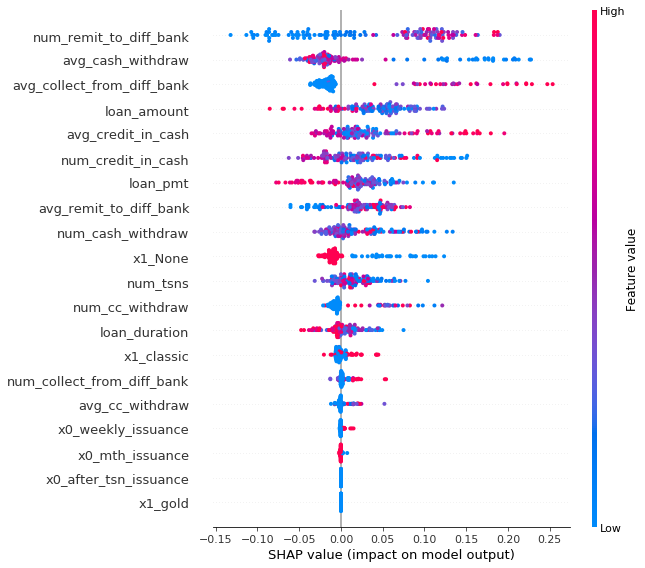

<Figure size 432x288 with 0 Axes>

In [0]:
# Shap values for bank loan approval.

shap.summary_plot(rf_shap_values[1],
                  features = X_val_transform_df,
                  feature_names = transformed_columns)



plt.savefig("shap.png")


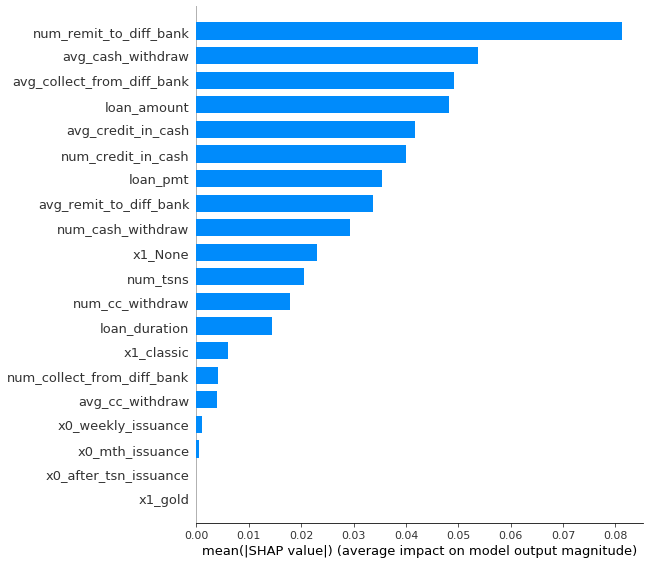

In [0]:
# Bar Plot of shap values (gives magnitude only, not direction):

shap.summary_plot(rf_shap_values[1], X_val_transform_df, plot_type = 'bar')

## Dependence Plots

In [0]:
# Top 5 Columns To Look At

top_five_cols = ['num_remit_to_diff_bank', 'avg_cash_withdraw', 'avg_collect_from_diff_bank',
                 'loan_amount', 'avg_credit_in_cash']

### Number Of Remittances To A Different Bank

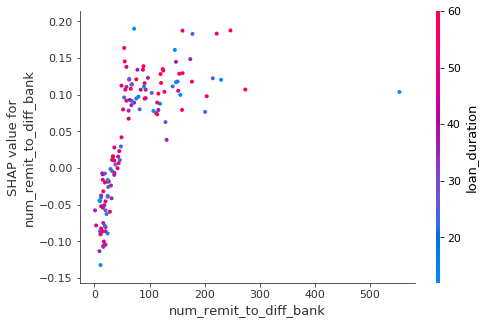

In [0]:
# Dependence Plots

shap.dependence_plot('num_remit_to_diff_bank',
                     rf_shap_values[1],
                     X_val_transform_df,
                     feature_names = transformed_columns,
                     interaction_index = 'loan_duration')


Higher number of remittances to different banks leads a higher likelihood of loan approval.

### Average Cash Withdrawals

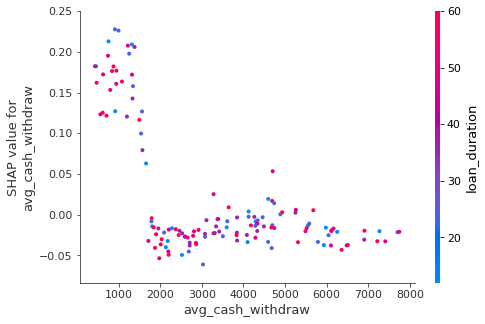

In [0]:
# Dependence Plots - avg_cash_withdraw

shap.dependence_plot('avg_cash_withdraw',
                     rf_shap_values[1],
                     X_val_transform_df,
                     feature_names = transformed_columns,
                     interaction_index = 'loan_duration')


A low average cash withdraw (less than 1500) leads to a higher bank loan approval.

Cash withdrawals of 1500 and more lead to a higher chance of a rejected bank loan approval.

### Average Collection From Different Bank

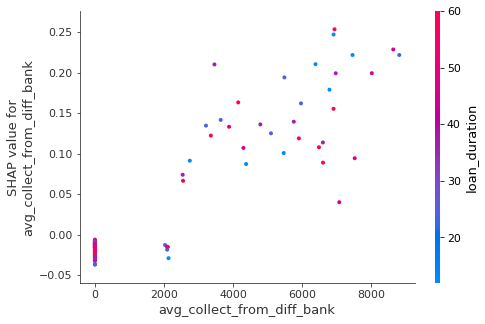

In [0]:
# Dependence Plots - avg_collection from different bank

shap.dependence_plot('avg_collect_from_diff_bank',
                     rf_shap_values[1],
                     X_val_transform_df,
                     feature_names = transformed_columns,
                     interaction_index = 'loan_duration')


An average collection from different bank higher than about 2200 leads to a higher chance of bank loan approval.

### Loan Amount

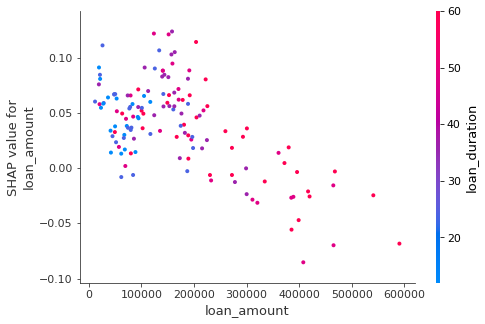

In [0]:
# Dependence Plots - Loan Amount

shap.dependence_plot('loan_amount',
                     rf_shap_values[1],
                     X_val_transform_df,
                     feature_names = transformed_columns,
                     interaction_index = 'loan_duration')


Loan amounts less than about 220000 give a slight increased chance of bank loan approval.

### Average Credit In Cash

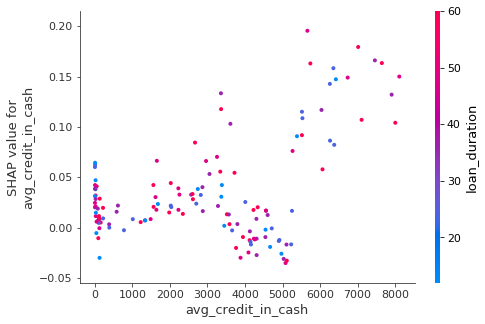

In [0]:
# Dependence Plots - avg_credit_in_cash

shap.dependence_plot('avg_credit_in_cash',
                     rf_shap_values[1],
                     X_val_transform_df,
                     feature_names = transformed_columns,
                     interaction_index = 'loan_duration')


Average credit in cash above 5000 leads to a higher chance of bank loan approval. 

Those in the 3000-5000 region generally leads to a higher chance of bank loan rejection.

For the less than 3000 region, there is a slightly higher chance of bank loan approval.